# Common tasks for every exercise:
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp

In [28]:
def clean_columns(df):
    df.columns = [col.strip() for col in df.columns]
    return df

def clean_values(df):
    df = df.applymap(lambda a: a.strip() if isinstance(a,str) else a)
    return df

def dec_cleaner(func):
    
    def wrapper(*args):
        
        return func(clean_values(clean_columns(*args)))
    
    return wrapper


@dec_cleaner
def explore_after_cleaning(df):
    return df

def generate_uniques_file(from_file):
    
    new_path = from_file[:from_file.find('.')] + '_unique.csv'
    
    with open(new_path, mode='w', newline='\n') as f:
        head = sp.Popen(['head','-n', '1', from_file],stdout=f)
        head.wait()
        pros = sp.Popen(['tail','-n', '+2', from_file],stdout=sp.PIPE)
        pros_2 = sp.Popen(['sort','-u'], stdin=pros.stdout, stdout=f)
        pros_2.wait()
    
    return new_path

def dec_duplicates(func):
    def wrapper(*args,**kwargs):
        
        arguments = dict(zip(func.__code__.co_varnames, args))
        arguments.update(kwargs)
        
        if arguments.get('treat_duplicates'):
            arguments['path'] = generate_uniques_file(arguments['path']) 
        return func(**arguments)
        
    return wrapper

@dec_duplicates
def accum_handler(func, path,chunk_size=1000, breaker=True, treat_duplicates=False, sep='^'): 
    reader = pd.read_csv(path, chunksize=chunk_size, delimiter=sep, engine='python')
    df = pd.DataFrame()
    for chunk in reader:
        df = pd.concat([df,func(chunk)])
        if breaker:
            reader.close()
            break
    return df

In [3]:
searches_path = 'challenge/searches.csv'
bookings_path = 'challenge/bookings.csv'

# Exercise 1
---

#### Common tasks for any variant of exercise 1:

In [4]:
def countlines(df):
    return pd.Series(len(df))

In [8]:
def prettify_outcome(s):
    return s.sum().apply(lambda v: '{:,.0f} rows'.format(v)).values[0]

#### Count rows **(with duplicates)** of bookings file:

In [10]:
counts = accum_handler(countlines, bookings_path,breaker=False, chunk_size=1000000)

In [11]:
prettify_outcome(counts.copy())

'10,000,010 rows'

#### Count rows **(without duplicates)** of searches file:

In [5]:
count_searches = accum_handler(countlines,searches_path,treat_duplicates= True,breaker=False,sep=r'\^|,', chunk_size=1000000)

In [6]:
count_searches

,0
0,359004.0


In [9]:
prettify_outcome(count_searches.copy())

'359,004 rows'

# Exercise 2
----

#### Common tasks for any variant of exercise 2:

In [13]:
@dec_cleaner
def sum_arrival_airports(df, n=10):
    return df.groupby('arr_port')['pax'].sum()

In [12]:
def group_n_behead(df,n=10):
    df = df.groupby(df.index).sum().sort_values(by=0,ascending=False)
    df.columns = ['Passengers']
    df['Passengers'] = df['Passengers'].apply(lambda v: '{:,.0f}'.format(v))
    return df.head(n)

In [14]:
def get_airport_names(df):
    path = 'https://raw.githubusercontent.com/opentraveldata/geobases/public/GeoBases/DataSources/Airports/GeoNames/airports_geonames_only_clean.csv'
    db = pd.read_csv(path, delimiter='^', names=['Code', 'Name', 'Code2', 'Country_code,', 'Country_name', 'lat','lon'])
    return pd.merge(df,db,how='inner',left_index=True,right_on='Code')[['Passengers','Code','Name']].set_index('Code')

#### Taking into account duplicates:

In [15]:
s = accum_handler(sum_arrival_airports, bookings_path,breaker=False, chunk_size=1000000)

In [17]:
summary = group_n_behead(s.copy())
summary

,Passengers
LHR,"88,809"
MCO,"70,930"
LAX,"70,530"
LAS,"69,630"
JFK,"66,270"
CDG,"64,490"
BKK,"59,460"
MIA,"58,150"
SFO,"58,000"
DXB,"55,590"


In [18]:
get_airport_names(summary.copy())

,Passengers,Name
Code,,
LHR,"88,809",London Heathrow Airport
MCO,"70,930",Orlando International Airport
LAX,"70,530",Los Angeles International Airport
LAS,"69,630",McCarran International Airport
JFK,"66,270",John F Kennedy International Airport
CDG,"64,490",Paris - Charles-de-Gaulle
BKK,"59,460",Suvarnabhumi
MIA,"58,150",Miami International Airport
SFO,"58,000",San Francisco International Airport


#### No duplicates:

In [26]:
ds = accum_handler(sum_arrival_airports, bookings_path,breaker=False,treat_duplicates=True, chunk_size=1000000)

challenge/bookings_unique.csv


In [27]:
dsummary = group_n_behead(ds.copy())
dsummary

,Passengers
LHR,"8,881"
MCO,"7,093"
LAX,"7,053"
LAS,"6,963"
JFK,"6,627"
CDG,"6,449"
BKK,"5,946"
MIA,"5,815"
SFO,"5,800"
DXB,"5,559"


In [21]:
get_airport_names(dsummary.copy())

,Passengers,Name
Code,,
LHR,"8,881",London Heathrow Airport
MCO,"7,093",Orlando International Airport
LAX,"7,053",Los Angeles International Airport
LAS,"6,963",McCarran International Airport
JFK,"6,627",John F Kennedy International Airport
CDG,"6,449",Paris - Charles-de-Gaulle
BKK,"5,946",Suvarnabhumi
MIA,"5,815",Miami International Airport
SFO,"5,800",San Francisco International Airport


 # Exercise 3
 ---

#### Common tasks for any variant of exercise 3:

In [29]:
iata_targets = {'AGP': 'Málaga',
               'BCN': 'Barcelona',
               'MAD': 'Madrid'}

In [30]:
@dec_cleaner
def count_searches_per_destination(df):
    df['Date'] = pd.to_datetime(df['Date'])
    pindex = pd.PeriodIndex(year=df['Date'].dt.year, month=df['Date'].dt.month, freq='M')
    df.index = pindex
    destinations = df.groupby([df.index,'Destination'])['Destination'].count()
    return destinations

In [31]:
def transform_and_group(df):
    df.columns= ['Destination_Count']
    df['Year-Month'] = df.index.str[0]
    df['Destination'] = df.index.str[1]
    group = df.groupby(['Year-Month','Destination'])['Destination_Count'].sum()
    return group

In [32]:
def pivot_table(df):
    df = df.reset_index(level=1)
    return pd.pivot(df,columns='Destination', values='Destination_Count')

In [33]:
def plot_series(table, targeted_airports):
    fig, ax = plt.subplots(1,1)
    x_vals = table.index.strftime('%Y-%m')
    for col in table[targeted_airports.keys()].columns:
        ax.plot(x_vals, table[col].values)

    ax.set_xticks(np.arange(len(table.index)))
    ax.set_xticklabels(labels=x_vals, rotation=90)
    ax.legend(labels=targeted_airports.values())
    ax.grid()
    return fig, ax

#### Taking into account duplicates:

In [34]:
dest = accum_handler(count_searches_per_destination, searches_path, chunk_size=100000,breaker=False,sep=r'\^|,')

In [35]:
searches_summary = transform_and_group(dest.copy())

In [36]:
searches_summary

Year-Month  Destination
2013-01     AAE             57.0
            AAL            342.0
            AAQ            285.0
            AAR            171.0
            ABA            114.0
                           ...  
2013-12     ZSA             56.0
            ZSE             56.0
            ZTF             56.0
            ZTH            336.0
            ZYA             56.0
Name: Destination_Count, Length: 19009, dtype: float64

In [37]:
pivot = pivot_table(searches_summary.copy())

In [38]:
pivot.head(10)

Destination,AAC,AAE,AAH,AAL,AAM,AAN,AAQ,AAR,AAV,AAX,...,ZTH,ZUH,ZVG,ZVJ,ZWE,ZWS,ZYA,ZYL,ZYR,ZYZ
Year-Month,,,,,,,,,,,,,,,,,,,,,
2013-01,NaN,57.0,NaN,342.0,NaN,NaN,285.0,171.0,NaN,NaN,...,228.0,57.0,NaN,57.0,NaN,114.0,NaN,57.0,NaN,NaN
2013-02,NaN,114.0,NaN,114.0,NaN,NaN,399.0,171.0,NaN,NaN,...,342.0,NaN,NaN,NaN,NaN,57.0,NaN,NaN,57.0,NaN
2013-03,NaN,285.0,NaN,342.0,NaN,NaN,627.0,171.0,NaN,NaN,...,513.0,NaN,NaN,NaN,NaN,114.0,57.0,57.0,NaN,NaN
2013-04,57.0,171.0,NaN,285.0,NaN,NaN,969.0,171.0,NaN,NaN,...,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,NaN
2013-05,NaN,171.0,NaN,342.0,NaN,NaN,1596.0,456.0,NaN,NaN,...,570.0,NaN,NaN,NaN,NaN,NaN,57.0,NaN,114.0,NaN
2013-06,NaN,285.0,57.0,228.0,57.0,NaN,2280.0,171.0,NaN,NaN,...,285.0,57.0,NaN,NaN,NaN,57.0,NaN,NaN,114.0,NaN
2013-07,NaN,114.0,NaN,171.0,NaN,NaN,1197.0,114.0,NaN,NaN,...,399.0,NaN,NaN,57.0,NaN,285.0,NaN,NaN,57.0,NaN
2013-08,NaN,NaN,NaN,456.0,NaN,NaN,1254.0,399.0,NaN,57.0,...,513.0,NaN,NaN,NaN,NaN,114.0,228.0,NaN,114.0,57.0
2013-09,NaN,57.0,57.0,342.0,NaN,171.0,399.0,114.0,NaN,NaN,...,228.0,NaN,NaN,171.0,NaN,NaN,NaN,57.0,57.0,NaN


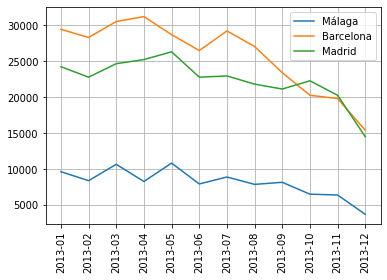

In [39]:
plot_series(pivot.copy(), iata_targets);

#### No duplicates:

In [40]:
ddest = accum_handler(count_searches_per_destination, searches_path, chunk_size=100000,breaker=False,sep=r'\^|,', treat_duplicates=True)

In [41]:
dsearches_summary = transform_and_group(ddest.copy())
dsearches_summary

Year-Month  Destination
2013-01     AAE            1.0
            AAL            6.0
            AAQ            5.0
            AAR            3.0
            ABA            2.0
                          ... 
2013-12     ZSA            1.0
            ZSE            1.0
            ZTF            1.0
            ZTH            6.0
            ZYA            1.0
Name: Destination_Count, Length: 19009, dtype: float64

In [42]:
dpivot = pivot_table(dsearches_summary.copy())
dpivot.head(10)

Destination,AAC,AAE,AAH,AAL,AAM,AAN,AAQ,AAR,AAV,AAX,...,ZTH,ZUH,ZVG,ZVJ,ZWE,ZWS,ZYA,ZYL,ZYR,ZYZ
Year-Month,,,,,,,,,,,,,,,,,,,,,
2013-01,NaN,1.0,NaN,6.0,NaN,NaN,5.0,3.0,NaN,NaN,...,4.0,1.0,NaN,1.0,NaN,2.0,NaN,1.0,NaN,NaN
2013-02,NaN,2.0,NaN,2.0,NaN,NaN,7.0,3.0,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
2013-03,NaN,5.0,NaN,6.0,NaN,NaN,11.0,3.0,NaN,NaN,...,9.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,NaN
2013-04,1.0,3.0,NaN,5.0,NaN,NaN,17.0,3.0,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2013-05,NaN,3.0,NaN,6.0,NaN,NaN,28.0,8.0,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN
2013-06,NaN,5.0,1.0,4.0,1.0,NaN,40.0,3.0,NaN,NaN,...,5.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN
2013-07,NaN,2.0,NaN,3.0,NaN,NaN,21.0,2.0,NaN,NaN,...,7.0,NaN,NaN,1.0,NaN,5.0,NaN,NaN,1.0,NaN
2013-08,NaN,NaN,NaN,8.0,NaN,NaN,22.0,7.0,NaN,1.0,...,9.0,NaN,NaN,NaN,NaN,2.0,4.0,NaN,2.0,1.0
2013-09,NaN,1.0,1.0,6.0,NaN,3.0,7.0,2.0,NaN,NaN,...,4.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,NaN


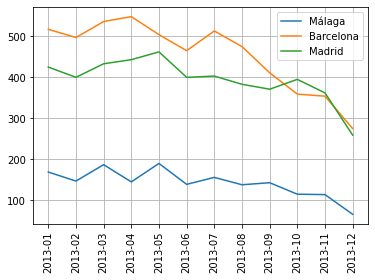

In [43]:
plot_series(dpivot.copy(), iata_targets);

# Exercise 4

In [25]:
searches_s = accum_handler(explore_after_cleaning,breaker=True, chunk_size=1000, path=searches_path)

<ipython-input-15-c7195490b50e>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  reader = pd.read_csv(path, chunksize=chunk_size, delimiter=',|\^')


In [29]:
searches_s

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,...,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,...,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2013-01-01,14:58:25,MPT,c8daef4f8bf73a61aa2c928705f7b82d,ES,ADB,DTM,0,1,ADB,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,MAD
996,2013-01-01,16:03:50,FXP,266a430550a2a2bf1ceb2e5b09f1991c,HK,HKG,PER,0,2,HKG,...,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,HKG
997,2013-01-01,02:16:11,MTP,0632d0675e69cac2473475b2261fc4b9,CA,YYZ,HKG,1,2,YYZ,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,YTO
998,2013-01-01,13:01:24,FFP,89cc49bf7febdbe40c1b7db87facb2ae,US,JRO,FRA,1,2,JRO,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC


In [30]:
bookings_s = accum_handler(explore_after_cleaning,breaker=True, chunk_size=1000)

<ipython-input-15-c7195490b50e>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  reader = pd.read_csv(path, chunksize=chunk_size, delimiter=',|\^')


In [31]:
bookings_s.head(10)

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,...,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,...,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NaN
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NaN
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NaN
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,...,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,...,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546
5,2013-03-20 00:00:00,1V,US,0283592e45e392871f7e14b1e22a9aaf,2d0f8e7e1bb792625d2f34f221bc38f1,d54708298686de200f8270e7c637af5e,2013-03-20 00:00:00,5923,0,DEN,...,DENLGA,FK,W,Y,2013-04-07 10:23:00,2013-04-07 16:14:24,1,2013,3,NaN
6,2013-03-20 00:00:00,1V,US,0283592e45e392871f7e14b1e22a9aaf,2d0f8e7e1bb792625d2f34f221bc38f1,d54708298686de200f8270e7c637af5e,2013-03-20 00:00:00,5923,0,DEN,...,LGADEN,FK,K,Y,2013-04-11 11:15:00,2013-04-11 13:06:24,1,2013,3,NaN
7,2013-03-25 00:00:00,1V,JP,5af045902bd23cab579915611d99e1e0,5073861d8597467c33596bfe16f23c56,a37584d1485cb35991e4ff1a2ba92262,2013-03-25 00:00:00,8371,60,NRT,...,NRTSIN,XR,Q,Y,2013-04-14 11:05:00,2013-04-14 17:10:56,2,2013,3,NaN
8,2013-03-25 00:00:00,1V,JP,5af045902bd23cab579915611d99e1e0,5073861d8597467c33596bfe16f23c56,a37584d1485cb35991e4ff1a2ba92262,2013-03-25 00:00:00,8371,60,NRT,...,SINPEN,WS,Y,Y,2013-04-16 15:45:00,2013-04-16 17:15:29,2,2013,3,NaN
9,2013-03-25 00:00:00,1V,JP,5af045902bd23cab579915611d99e1e0,5073861d8597467c33596bfe16f23c56,a37584d1485cb35991e4ff1a2ba92262,2013-03-25 00:00:00,8371,60,NRT,...,PENBKK,EQ,Y,Y,2013-04-18 08:00:00,2013-04-18 08:53:56,2,2013,3,NaN


In [32]:
bookings_s.columns

Index(['act_date', 'source', 'pos_ctry', 'pos_iata', 'pos_oid', 'rloc',
       'cre_date', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry',
       'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry',
       'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry',
       'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route', 'carrier',
       'bkg_class', 'cab_class', 'brd_time', 'off_time', 'pax', 'year',
       'month', 'oid'],
      dtype='object')

In [33]:
searches_s.columns

Index(['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin',
       'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure',
       'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode',
       'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier',
       'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date',
       'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival',
       'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure',
       'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode',
       'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier',
       'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet',
       'IsFromVista', 'TerminalID', 'InternetOffice'],
      dtype='object')